In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import spacy
import nltk
import re   # regular expression
import string
import scipy.sparse as sp
import joblib
import emoji
from autocorrect import Speller   # for correcting spelling
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize    # for tokenizing string into words
from nltk.stem import WordNetLemmatizer    # for lemmatizing words
from nltk.tag import pos_tag # for tagging words with their parts of speech (POS)

In [3]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance # for feature selection using KNN
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

In [4]:
# nltk.download('all-corpora')
# nltk.download('punkt')  # for using word_tokenizer
# nltk.download('wordnet')  # for using Lemmatizer
# nltk.download('averaged_perceptron_tagger') # for language processing i.e tagging words with their parts of speech (POS)
# !python -m spacy download en_core_web_lg

To read multiple sheets in a excel file using pandas:

Specify sheet_name = None in pd.read_excel() function, we get a dictionary of Pandas DataFrames, where the keys are the names of the worksheets, and the values are the data in each worksheet as Pandas DataFrames.

In [5]:
df_Com = pd.read_excel("C:/Users/akash/Downloads/Movie Reviews data/Comedy Reviews.xlsx", header=None, sheet_name = None)
print(df_Com)

{'GULLAK':                                                      0
0                                            Nostalgic
1             TVF has done it again, Brilliant series.
2    Please dont stop. Continue journey with Season...
3    Story which will seriously tickle it's audienc...
4                                Must watch web series
..                                                 ...
687  This show has everything right except the ster...
688  I watched the series very recently and enjoyed...
689  Typical TVF look a like show, with good hardwo...
690  I would have given this season a rating of 9, ...
691  Centred around the middle class Mishra family ...

[692 rows x 1 columns], 'PITCHERS':                                                      0
0    I occasionally review any shows or web series ...
1    I never write any review before but this time ...
2    Serials, movies and web series all have a fix ...
3    Showcased the life of a young IT employee and ...
4    The best web

In [6]:
print('no. of sheets in df_Comedy is : ', len(df_Com))

no. of sheets in df_Comedy is :  10


In [7]:
# to get name of all keys in a dict
df_Com_keys = list(df_Com.keys())
print(df_Com_keys)

['GULLAK', 'PITCHERS', 'YEH MERI FAMILY', 'COLLEGE ROMANCE', 'PANCHAYAT', 'HOSTEL DAZE', 'CHACHA VIDHAYAK HAI HUMARE', 'PUSHPAVALLI', 'COMICSTAAN', 'MIND THE MALHOTRAS']


To analyse data from a specific worksheet.

In [8]:
# Get data from 'GULLAK' worksheet
df_Com_GULLAK = df_Com['GULLAK']
print(df_Com_GULLAK.shape)
# Preview
df_Com_GULLAK.head()

(692, 1)


,0
0,Nostalgic
1,"TVF has done it again, Brilliant series."
2,Please dont stop. Continue journey with Season...
3,Story which will seriously tickle it's audienc...
4,Must watch web series


In [9]:
df_Cr = pd.read_excel("C:/Users/akash/Downloads/Movie Reviews data/Crime Reviews.xlsx", header=None, sheet_name = None)
print('no. of sheets in Crime is : ', len(df_Cr))
df_Dr = pd.read_excel("C:/Users/akash/Downloads/Movie Reviews data/Drama Reviews.xlsx", header=None, sheet_name = None)
print('no. of sheets in Drama is : ', len(df_Dr))
df_Th = pd.read_excel("C:/Users/akash/Downloads/Movie Reviews data/Thriller Reviews.xlsx", header=None, sheet_name = None)
print('no. of sheets in Thriller is : ', len(df_Th))

no. of sheets in Crime is :  15
no. of sheets in Drama is :  10
no. of sheets in Thriller is :  15


In [10]:
# function to create a dataframe with each webseries & its comments as a row
def convert_worksheet_to_rows(df):
  # create aa dictinary with 2 keys webseries name and comments so that these 2 are cols in final df
  web_dict = {}
  # list for comments for each webseries
  comment = []
  # list for name of webseries
  webseries_name = []

  # to get name of all keys in a dict
  df_keys = list(df.keys())
  for webseries_name in df_keys:
    # Get data from eac worksheet in df
    df_webseries = df[webseries]
    df_webseries.fillna('series', inplace=True) # to replace nan values
    # converting a dataframe as a single row
    sentlst = df_webseries[0].tolist()  # getting 1st col of dataframe and converting to list
    sentlsts = [str(s) for s in sentlst]
    sent = " ".join(sentlsts)

    # appending webseries name and its comments
    webseries_name.append(webseries)
    comment.append(sent)

  web_dict['webseries'] = webseries_name
  web_dict['comment'] = comment
  df_new = pd.DataFrame.from_dict(web_dict)

  return df_new


In [11]:
df_comedy = convert_worksheet_to_rows(df_Com)
print('shape of df_comedy is : ', df_comedy.shape)
df_crime = convert_worksheet_to_rows(df_Cr)
print('shape of df_crime is : ', df_crime.shape)
df_drama = convert_worksheet_to_rows(df_Dr)
print('shape of df_drama is : ', df_drama.shape)
df_thriller = convert_worksheet_to_rows(df_Th)
print('shape of df_thriller is : ', df_thriller.shape)

shape of df_comedy is :  (10, 2)
shape of df_crime is :  (15, 2)
shape of df_drama is :  (10, 2)
shape of df_thriller is :  (15, 2)


In [12]:
# just to check
df_drama.head()

,webseries,comment
0,ASPIRANTS,"This series is really inspiring, good message,..."
1,KOTA FACTORY,KOTA FACTORY\nI have always felt the story of ...
2,KAAFIR,"Purity, Goodness, love touches you, gets insid..."
3,MADE IN HEAVEN,Cant thank enough to Zoya for this beautiful p...
4,LITTLE THINGS,This has gotta be the BEST Indian show on a st...


In [13]:
# merge all dfs
df_combined = pd.concat([df_comedy, df_crime, df_drama, df_thriller], ignore_index=True)
print(df_combined.shape)
df_combined.head()

(50, 2)


,webseries,comment
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser..."
1,PITCHERS,I occasionally review any shows or web series ...
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...
4,PANCHAYAT,TVF is known to produce content which is roote...


In [14]:
# english Stopwords
stopwords_list = stopwords.words('english')
stws = ['ok','series','watch','story','show','season','web','actors','actor','episode','episodes','see','slightly','app','thumbs','ott','webseries','tvf','netflix', 'mx player', 'amazon prime','hotstar']
for sw in stws:
    stopwords_list.append(sw)
    
# remove negative words from stopwords_list so that we dont loose the negative meaning
remove_words =  ['against','no','nor','not',"don't",'ain',"aren't",'aren','couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
for sn in remove_words:
    stopwords_list.remove(sn)

In [15]:
# used this dictionary for expanding conracted words. this is taken from Github
CONTRACTIONS = {
    "I'm": "I am",
    "I'm'a": "I am about to",
    "I'm'o": "I am going to",
    "I've": "I have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'd": "I would",
    "I'd've": "I would have",
    "Whatcha": "What are you",
    "amn't": "am not",
    # -----------------------------
    # these below some words taken from stopword list and i think it is am not
    'ain' : 'am not',  
    'aren':'are not',
    'couldn':'could not',
    'didn':'did not',
    'doesn':'does not',
    'hadn':'had not',
    'hasn':'has not',
    'haven':'have not',
    'isn':'is not',
    'mightn':'might not',
    'mustn':'must not',
    'needn':'need not',
    'shan':'shall not',
    'shouldn':'should not',
    'wasn':'was not',
    'weren':'were not',
    'won':'will not',
    'wouldn':'would not',
    # -----------------------------
    "ain't": "are not",
    "aren't": "are not",
    "'cause": "because",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "didn’t": "did not",
    "don't": "do not",
    "don’t": "do not",
    "doesn't": "does not",
    "e'er": "ever",
    "everyone's": "everyone is",
    "finna": "fixing to",
    "gimme": "give me",
    "gon't": "go not",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he've": "he have",
    "he's": "he is",
    "he'll": "he will",
    "he'll've": "he will have",
    "he'd": "he would",
    "he'd've": "he would have",
    "here's": "here is",
    "how're": "how are",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how's": "how is",
    "how'll": "how will",
    "isn't": "is not",
    "it's": "it is",
    "'tis": "it is",
    "'twas": "it was",
    "it'll": "it will",
    "it'll've": "it will have",
    "it'd": "it would",
    "it'd've": "it would have",
    "kinda": "kind of",
    "let's": "let us",
    "luv": "love",
    "ma'am": "madam",
    "may've": "may have",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "ne'er": "never",
    "o'": "of",
    "o'clock": "of the clock",
    "ol'": "old",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "o'er": "over",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shalln't": "shall not",
    "shan't've": "shall not have",
    "she's": "she is",
    "she'll": "she will",
    "she'd": "she would",
    "she'd've": "she would have",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "somebody's": "somebody is",
    "someone's": "someone is",
    "something's": "something is",
    "sux": "sucks",
    "that're": "that are",
    "that's": "that is",
    "that'll": "that will",
    "that'd": "that would",
    "that'd've": "that would have",
    "em": "them",
    "there're": "there are",
    "there's": "there is",
    "there'll": "there will",
    "there'd": "there would",
    "there'd've": "there would have",
    "these're": "these are",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they'd": "they would",
    "they'd've": "they would have",
    "this's": "this is",
    "those're": "those are",
    "to've": "to have",
    "wanna": "want to",
    "wasn't": "was not",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we'd": "we would",
    "we'd've": "we would have",
    "weren't": "were not",
    "what're": "what are",
    "what'd": "what did",
    "what've": "what have",
    "what's": "what is",
    "what'll": "what will",
    "what'll've": "what will have",
    "when've": "when have",
    "when's": "when is",
    "where're": "where are",
    "where'd": "where did",
    "where've": "where have",
    "where's": "where is",
    "which's": "which is",
    "who're": "who are",
    "who've": "who have",
    "who's": "who is",
    "who'll": "who will",
    "who'll've": "who will have",
    "who'd": "who would",
    "who'd've": "who would have",
    "why're": "why are",
    "why'd": "why did",
    "why've": "why have",
    "why's": "why is",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "you're": "you are",
    "you've": "you have",
    "you'll've": "you shall have",
    "you'll": "you will",
    "you'd": "you would",
    "you'd've": "you would have"
 }

In [16]:
#I created a dictionary for emoticons
EMOTICONS = {
    u":‑)":"Happy",
    u":-))":"Very Happy",
    u":-)))":"Very very Happy",
    u":)":"Happy",
    u":))":"Very Happy",
    u":)))":"Very very Happy",
    u":-]":"Happy",
    u":]":"Happy",
    u":-3":"Happy",
    u":3":"Happy",
    u":->":"Happy",
    u":>":"Happy",
    u"8-)":"Happy",
    u":o)":"Happy",
    u":-}":"Happy",
    u":}":"Happy",
    u":-)":"Happy",
    u":c)":"Happy",
    u":^)":"Happy",
    u"=]":"Happy",
    u"=)":"Happy",
    u":‑D":"Laughing",
    u":D":"Laughing",
    u"8‑D":"Laughing",
    u"8D":"Laughing",
    u"X‑D":"Laughing",
    u"XD":"Laughing",
    u"=D":"Laughing",
    u"=3":"Laughing",
    u"B^D":"Laughing",
    u":-))":"Very happy",
    u"<3":"love",
    u":-(":"sad",
    u":‑(":"sad",
    u":(":"sad",
    u":‑c":"sad",
    u":c":"sad",
    u":‑<":"sad",
    u":<":"sad",
    u":‑[":"sad",
    u":[":"sad",
    u":-||":"sad",
    u">:[":"sad",
    u":{":"sad",
    u":@":"sad",
    u">:(":"sad",
    u":'‑(":"Crying",
    u":'(":"Crying",
    u":'‑)":"Tears of happiness",
    u":')":"Tears of happiness",
    u"D‑':":"sad",
    u"D:<":"sad",
    u"D:":"sad",
    u"D8":"very sad",
    u"D;":"very sad",
    u"D=":"very sad",
    u"DX":"very sad",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Sad",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-*":"Kiss",
    u":*":"Kiss",
    u":X":"Kiss",
    u";‑)":"Wink",
    u";)":"Wink",
    u"*-)":"Wink",
    u"*)":"Wink",
    u";‑]":"Wink",
    u";]":"Wink",
    u";^)":"Wink",
    u":‑,":"Wink",
    u";D":"Wink",
    u":‑P":"fun",
    u":P":"fun",
    u"X‑P":"fun",
    u"XP":"fun",
    u":‑Þ":"fun",
    u":Þ":"fun",
    u":b":"fun",
    u"d:":"fun",
    u"=p":"fun",
    u">:P":"fun",
    u":‑/":"annoyed",
    u":/":"annoyed",
    u":-[.]":"annoyed",
    u">:[(\)]":"annoyed",
    u">:/":"annoyed",
    u":[(\)]":"annoyed",
    u"=/":"annoyed",
    u"=[(\)]":"annoyed",
    u":L":"annoyed",
    u"=L":"annoyed",
    u":S":"annoyed",
    u":‑|":"indecision",
    u":|":"indecision",
    u":$":"Embarrassed",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑)":"Angel",
    u"O:)":"Angel",
    u"0:‑3":"Angel",
    u"0:3":"Angel",
    u"0:‑)":"Angel",
    u"0:)":"Angel",
    u":‑b":"fun",
    u"0;^)":"Angel",
    u">:‑)":"devilish",
    u">:)":"devilish",
    u"}:‑)":"devilish",
    u"}:)":"devilish",
    u"3:‑)":"devilish",
    u"3:)":"devilish",
    u">;)":"devilish",
    u"|;‑)":"Cool",
    u"|‑O":"Bored",
    u":‑J":"Tongue in cheek",
    u"#‑)":"Party all night",
    u"%‑)":"confused",
    u"%)":"confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑|":"silent",
    u"(>_<)":"Troubled",
    u"(>_<)>":"Troubled",
    u"(';')":"Baby",
    u"(^^>``":"Nervous",
    u"(^_^;)":"Troubled",
    u"(-_-;)":"Nervous",
    u"(~_~;) (・.・;)":"Shy",
    u"(-_-)zzz":"Sleeping",
    u"(^_-)":"Wink",
    u"((+_+))":"Confused",
    u"(+o+)":"Confused",
    u"(o|o)":"Ultraman",
    u"^_^":"happy",
    u"(^_^)/":"happy",
    u"(^O^)／":"happy",
    u"(^o^)／":"happy",
    u"(__)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_(._.)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<(_ _)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m(__)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(__)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m(_ _)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"('_')":"Sad",
    u"(/_;)":"Sad",
    u"(T_T) (;_;)":"Sad",
    u"(;_;":"Sad",
    u"(;_:)":"Sad",
    u"(;O;)":"Sad",
    u"(:_;)":"Sad",
    u"(ToT)":"Sad",
    u";_;":"Sad",
    u";-;":"Sad",
    u";n;":"Sad",
    u";;":"Sad",
    u"Q.Q":"Sad",
    u"T.T":"Sad",
    u"QQ":"Sad",
    u"Q_Q":"Sad",
    u"(-.-)":"Shame",
    u"(-_-)":"Shame",
    u"(一一)":"Shame",
    u"(；一_一)":"Shame",
    u"(=_=)":"Tired",
    u"(=^·^=)":"cat",
    u"(=^··^=)":"cat",
    u"=_^= ":"cat",
    u"(..)":"Looking down",
    u"(._.)":"Looking down",
    u"^m^":"Giggling",
    u"(・・?":"Confusion",
    u"(?_?)":"Confusion",
    u">^_^<":"Normal Laugh",
    u"<^!^>":"Normal Laugh",
    u"^/^":"Normal Laugh",
    u"（*^_^*）" :"Normal Laugh",
    u"(^<^) (^.^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^.^)":"Normal Laugh",
    u"(^_^.)":"Normal Laugh",
    u"(^_^)":"Normal Laugh",
    u"(^^)":"Normal Laugh",
    u"(^J^)":"Normal Laugh",
    u"(*^.^*)":"Normal Laugh",
    u"(^—^）":"Normal Laugh",
    u"(#^.^#)":"Normal Laugh",
    u"（^—^）":"Waving",
    u"(;_;)/~~~":"Waving",
    u"(^.^)/~~~":"Waving",
    u"(-_-)/~~~ ($··)/~~~":"Waving",
    u"(T_T)/~~~":"Waving",
    u"(ToT)/~~~":"Waving",
    u"(*^0^*)":"Excited",
    u"(*_*)":"Excited",
    u"(*_*;":"Excited",
    u"(+_+) (@_@)":"Excited",
    u"(*^^)v":"Cheerful",
    u"(^_^)v":"Cheerful",
    u"((d[-_-]b))":"Headphones,Listening to music",
    u'(-"-)':"Worried",
    u"(ーー;)":"Worried",
    u"(^0_0^)":"Eyeglasses",
    u"(＾ｖ＾)":"Happy",
    u"(＾ｕ＾)":"Happy",
    u"(^)o(^)":"Happy",
    u"(^O^)":"Happy",
    u"(^o^)":"Happy",
    u")^o^(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o.O":"Surpised",
    u"(o.o)":"Surprised",
    u"oO":"Surprised",
    u"(*￣m￣)":"Dissatisfied",
    u"(‘A`)":"Deflated"

}

In [17]:
def clean_text(tweet):
    
    tweet = tweet.lower() 
    tweet = tweet.split()
    tw = []
    for t in tweet:
        # removing digits only
        if t.isnumeric():
            continue
        else:
            pass
        if len(t)<=20 and len(t)>= 2:
            if len(set(t))<=1:
              continue
            if (sum(c.isalpha() for c in t) - sum(c.isdigit() for c in t)) <= 2: # to remove words like '1st', '2nd'
              continue
            if sum(c.isdigit() for c in t) >= sum(c.isalpha() for c in t): # to remove words with more nos.
              continue
            tw.append(t)
    tweet = ' '.join(tw)   
    # remove any urls
    tweet = re.sub(r"www\S+|http\S+|", "",tweet, flags = re.MULTILINE)
    # remove square bracket including its content if
    tweet = re.sub(r'\[|\]'," ",tweet)
    # to remove new line character
    tweet = re.sub(r'\n', " ", tweet)
    # remove user @ references and '#' from tweet
    tweet = re.sub(r"\@\w+|\#", "",tweet)
    # remove tags
    tweet = re.sub(re.compile('<.*?>'), '', tweet)

    if len(tweet) <= 1:   # if after pre-processing sent. has no letter
        tweet = 'movie'
    return tweet

In [18]:
def pre_process_emojis(tweet):
    
    # replace emojis with its meaning
    tweet = (emoji.demojize(tweet, delimiters=(" ", ""))).replace('_',' ')
    # expand contractions
    splitted_string = tweet.split()
    for index, text in enumerate(splitted_string):
        if text in CONTRACTIONS.keys():
            splitted_string[index] = CONTRACTIONS[text]
    tweet = ' '.join(splitted_string)
    # replace emoticons with its meaning
    splitted_tweet = tweet.split()
    for index, word in enumerate(splitted_tweet):
        if word in EMOTICONS.keys():
            splitted_tweet[index] = EMOTICONS[word]
    tweet = ' '.join(splitted_tweet)
    
    return tweet

In [19]:
def pre_process_stopwords(tweet):
    # remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    # remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stopwords_list]
    # spelling correction
    correct_words = []
    # initialize Speller object for english language
    spell_corrector = Speller(lang='en')
    for word in filtered_words:
        correct_word = spell_corrector(word)
        correct_words.append(correct_word)

    tweet = " ".join(correct_words)
    if len(tweet) <= 1:   # if after pre-processing sent. has no letter
        tweet = 'movie'
    return tweet

In [20]:
def pre_process_lemmatization(tweet):
    tweet = tweet.split()
    # lemmatizing
    wnl = WordNetLemmatizer()
    lemma_words = []
    for word, tag in pos_tag(tweet):      # Part-of-speech constants for ADJ,VERB,ADV = 'a', 'r', 'v'
        if tag.startswith('JJ'):      # for adjectives
            lemma_word = wnl.lemmatize(word, pos='a')
            lemma_words.append(lemma_word)
        elif tag.startswith('VB'):   # for verbs
            lemma_word = wnl.lemmatize(word, pos='v')
            lemma_words.append(lemma_word)
        elif tag.startswith('RB'):   # for adverbs
            lemma_word = wnl.lemmatize(word, pos='r')
            lemma_words.append(lemma_word)
        else:
            lemma_word = word
            lemma_words.append(lemma_word)
        
    tweet = " ".join(lemma_words)
    if len(tweet) <= 0:   # if after pre-processing sent. has no letter
        tweet = 'movie'
    return tweet

In [21]:
# cleaning
df_cleaned1 = df_combined['comment'].apply(clean_text)
df_cleaned2 =df_cleaned1.apply(pre_process_emojis)
df_cleaned3 = df_cleaned2.apply(pre_process_stopwords)
df_cleaned4 = df_cleaned3.apply(pre_process_lemmatization)

df_combined.insert(loc = 2,
        column = 'Cleaned Text',
        value = df_cleaned4)
#saving
df_combined.to_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Cleaned Text.csv',index=False)

In [5]:
dfcln = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Cleaned Text.csv')
dfcln.head()

,webseries,comment,Cleaned Text
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...


In [8]:
#dfcln['comment'][0]

'Nostalgic TVF has done it again, Brilliant series. Please dont stop. Continue journey with Season 3,4,5 and so on... Story which will seriously tickle it\'s audience for sure.. Must watch web series Need Season 3 TVF Impress Everytime Best web series of the year Takes you back in time. Very well directed Best Tv series One of the best from TVF Loved it! One the best web series Must watch for every household! Amazing Show, close to my heart It\'s beautiful Superb cast and beautiful episodes TVF has done again, a fantastic job None less than season 1 Simplicity at it\'s finest!! I cried watching this Ye zindagi yaado ki Gullak si... TVF MEANS HAPPINESS. Bestest series for this year TVF... RULES AGAIN !! One for ages Out of this world I wish I could gove more than 10 Simplicity at its best. Must watch! Mind Blowing Truely Awesome, reminds our childhood days Simply hilarious! Such a well made show Fabulous show !! Nostalgic! Just beautiful Real Excellent series....is there a second season

In [6]:
dfcln.shape

(50, 3)

### Word Cloud

In [24]:
dfcln.isnull().sum()

webseries       0
comment         0
Cleaned Text    0
dtype: int64

In [25]:
# dfcln.fillna('series', inplace=True) # to replace nan values
# dfcln.isnull().sum()

In [26]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [27]:
# converting a dataframe as a single row
sentlst = dfcln['Cleaned Text'].tolist()
sent = " ".join(sentlst)
# print(sent) # is just one sentence containing whole dataframe


# to create ngram from a sentence
words = nltk.word_tokenize(sent)

# say unigram
unigram = list(nltk.ngrams(words,1))
# since the value in uniigram is [('active',), ('covid19',), ('cases',), ('stand',), ('people',)], which is not in format
# ['active', 'covid19', 'cases', 'stand', 'people'] which nltk.FreqDist() accepts. So change the format
ungram = []
for i in range(len(unigram)):
    ungram.append(unigram[i][0])
    
#print(ungram[:5])


# for bigram format is fine
bigram = list(nltk.ngrams(words,2)) # o/p is a list of tuples containing bigram words: [('shut', 'main'),('main', 'reactor')]
# say trigram
trigram = list(nltk.ngrams(words,3)) 

# combining words in bigram list to a whole bigram word : 'shut main'
for i in range(0,len(bigram)): 
    bigram[i] = " ".join(bigram[i])

# for trigram
for i in range(0,len(trigram)): 
    trigram[i] = " ".join(trigram[i])    


# frequecy distribution 
unigram_Freq = nltk.FreqDist(ungram)
#print(unigram_Freq)

bigram_Freq = nltk.FreqDist(bigram) # has bigram words in order with their frquency, high is first then lower words
#print(bigram_Freq)

trigram_Freq = nltk.FreqDist(trigram)
#print(trigram_Freq)

In [28]:
import warnings
warnings.filterwarnings("ignore")

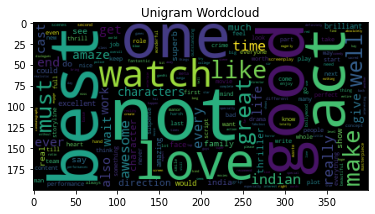

In [29]:
# bigram word cloud
unigram_wordcloud = WordCloud().generate_from_frequencies(unigram_Freq)
plt.gca().imshow(unigram_wordcloud)
plt.title("Unigram Wordcloud")
plt.show()

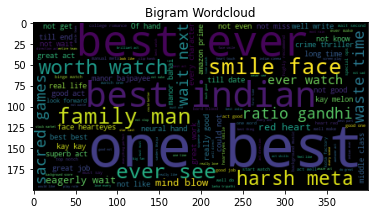

In [30]:
# bigram word cloud
bigram_wordcloud = WordCloud(random_state = 21).generate_from_frequencies(bigram_Freq)
plt.gca().imshow(bigram_wordcloud)
plt.title("Bigram Wordcloud")
plt.show()

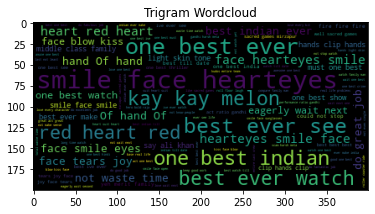

In [31]:
# trigram word cloud
trigram_wordcloud = WordCloud(random_state = 25).generate_from_frequencies(trigram_Freq)
plt.gca().imshow(trigram_wordcloud)
plt.title("Trigram Wordcloud")
plt.show()

### Semantic Network

In [ ]:
# !pip install phik

In [4]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [5]:
# By default, the library drops the NaNs from the data for calculating the correlation coefficient.

__We are finding correlation coefficient on bigrams. So find bigram using BoW.__

In [6]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [7]:
dg = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Cleaned Text.csv')
dg.head()

,webseries,comment,Cleaned Text
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...


In [8]:
dg.isnull().sum()

webseries       0
comment         0
Cleaned Text    0
dtype: int64

In [9]:
# dg.fillna('series', inplace=True) # to replace nan values
# dg.isnull().sum()

In [10]:
dglst = dg['Cleaned Text'].tolist()

In [11]:
CV = CountVectorizer(ngram_range=(2,2),max_features=5000) # (2,2) means Bigrams
df_cv = CV.fit_transform(dglst)
df_cv.shape

(50, 5000)

In [12]:
dfcv_array = df_cv.toarray()
dfcv = pd.DataFrame(data=dfcv_array,columns = CV.get_feature_names())
dfcv.head()

,aad hind,abbr khan,abhimanyu singh,abhishek bachchan,abhishek banerjee,able relate,able stop,abrupt end,absolute gem,absolute masterpiece,...,zombie apocalypse,zombie genre,zombie horror,zombie movie,zombie movies,zombie thriller,zombies look,zombies not,zona altar,zona hussain
0,0,0,0,0,0,1,1,0,2,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,6,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,3,1,0,2,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# correlation matrix
matrixi = dfcv.corr()
matrixi.iloc[:5, :5] # to print only 5 rows and 5 columns

,aad hind,abbr khan,abhimanyu singh,abhishek bachchan,abhishek banerjee
aad hind,1.000000,1.000000,-0.021948,-0.026205,-0.020408
abbr khan,1.000000,1.000000,-0.021948,-0.026205,-0.020408
abhimanyu singh,-0.021948,-0.021948,1.000000,-0.028182,-0.021948
abhishek bachchan,-0.026205,-0.026205,-0.028182,1.000000,-0.026205
abhishek banerjee,-0.020408,-0.020408,-0.021948,-0.026205,1.000000


In [14]:
matrix = matrixi.where(np.tril(np.ones(matrixi.shape),k=-1).astype(np.bool)) # lower triangular matrix without diagonal elements(k=-1)
matrix.iloc[:5, :5]

,aad hind,abbr khan,abhimanyu singh,abhishek bachchan,abhishek banerjee
aad hind,NaN,NaN,NaN,NaN,NaN
abbr khan,1.000000,NaN,NaN,NaN,NaN
abhimanyu singh,-0.021948,-0.021948,NaN,NaN,NaN
abhishek bachchan,-0.026205,-0.026205,-0.028182,NaN,NaN
abhishek banerjee,-0.020408,-0.020408,-0.021948,-0.026205,NaN


In [15]:
type(matrix)

pandas.core.frame.DataFrame

In [16]:
vl = matrix.iloc[0]
vl

aad hind            NaN
abbr khan           NaN
abhimanyu singh     NaN
abhishek bachchan   NaN
abhishek banerjee   NaN
                     ..
zombie thriller     NaN
zombies look        NaN
zombies not         NaN
zona altar          NaN
zona hussain        NaN
Name: aad hind, Length: 5000, dtype: float64

In [17]:
idx = matrix.index
idx

Index(['aad hind', 'abbr khan', 'abhimanyu singh', 'abhishek bachchan',
       'abhishek banerjee', 'able relate', 'able stop', 'abrupt end',
       'absolute gem', 'absolute masterpiece',
       ...
       'zombie apocalypse', 'zombie genre', 'zombie horror', 'zombie movie',
       'zombie movies', 'zombie thriller', 'zombies look', 'zombies not',
       'zona altar', 'zona hussain'],
      dtype='object', length=5000)

##### To remove corr values less than corr threshold.

In [19]:
corr_thres = 0.8 # enter positive correleation threshold value to only consider those correlataion after
# threshold for eg., if corr_thres = 0.6 then the final correlation matrix (corr) will only
# have values [-1 < corr < -0.6 and 0.6 < corr < 1]

node1 = []
node2 = []
weights = []
for i in range(len(idx)):
    vl = matrix.iloc[i]
    for j in range(len(vl)):
        if pd.isna(vl[j]): #to check if the value is null/NaN
            break # if Nan then not go for next column
        else:
            weight = vl[j].round(4)
            if (-corr_thres > weight) or (weight > corr_thres): # keep all corr vlaues >corr_thres or  <-corr_thres
                node1.append(idx[i])
                node2.append(idx[j])
                weights.append(weight)
            


print(node1[:5])
print()
print(node2[:5])
print()
print(weights[:5])

['abbr khan', 'act awesome', 'act bg', 'act brilliant', 'act direction']

['aad hind', 'act amaze', 'act background', 'act best', 'act background']

[1.0, 0.8048, 0.9071, 0.8074, 0.8032]


In [20]:
print(len(node1))
print(len(node2))
print(len(weights))

43619
43619
43619


In [21]:
# initialize data of lists.
data = {'node1': node1,
        'node2': node2,
        'weight': weights}

# Create DataFrame
df = pd.DataFrame(data)
df.head()

,node1,node2,weight
0,abbr khan,aad hind,1.0000
1,act awesome,act amaze,0.8048
2,act bg,act background,0.9071
3,act brilliant,act best,0.8074
4,act direction,act background,0.8032


In [38]:
dfh = df[:30]
dfh.head()

,node1,node2,weight
0,abbr khan,aad hind,1.0000
1,act awesome,act amaze,0.8048
2,act bg,act background,0.9071
3,act brilliant,act best,0.8074
4,act direction,act background,0.8032


In [39]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [40]:
G = nx.from_pandas_edgelist(dfh, source='node1', target='node2', edge_attr= "weight")

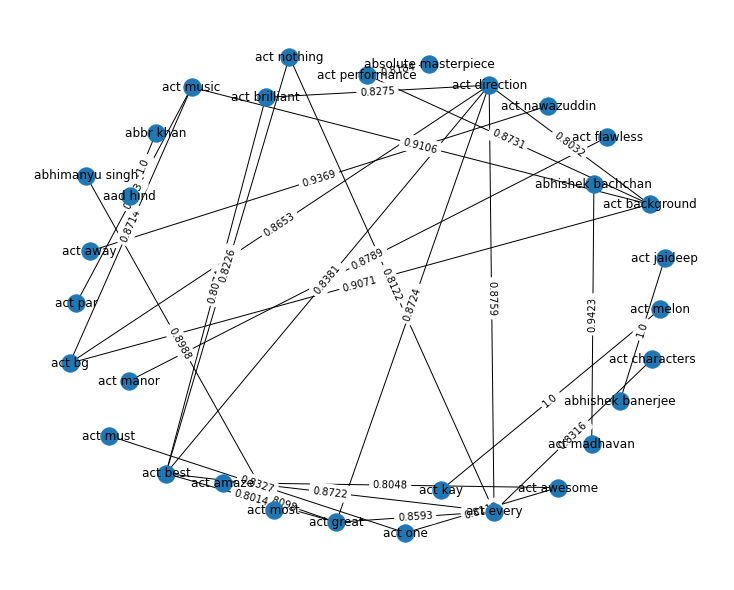

In [41]:
figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=12)
nx.draw(G, pos, with_labels=True)
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

# Topic Modelling

## LDA

### Using SKLEARN

In [55]:
dfcln = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Cleaned Text.csv')
dfcln.head()

,webseries,comment,Cleaned Text
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...


In [56]:
dfcln.isnull().sum()

webseries       0
comment         0
Cleaned Text    0
dtype: int64

#### Tf-idf

In [57]:
dflst = dfcln['Cleaned Text'].tolist()
tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=100000,use_idf=True,smooth_idf=True)
dv_tfidf = tfidf.fit_transform(dflst)
dv_tfidf.shape

(50, 100000)

In [68]:
from sklearn.decomposition import LatentDirichletAllocation

In [71]:
def num_topics(df_vector):
    lda = LatentDirichletAllocation()
    parameters = {
        'n_components': [4,5,6],      
        'learning_decay':[0.5,0.7,0.9]
        }
    grid_search1 = GridSearchCV(estimator=lda, param_grid=parameters,cv = 2)
    grid_search1.fit(df_vector)

    # The best model is
    clf1 = grid_search1.best_estimator_
    print('\n\n The best set of parameters of the pipeline are: ')
    print(grid_search1.best_params_)
    # Log Likelihood Score
    print("\n Best Log Likelihood Score: ", grid_search1.best_score_)
    # Perplexity
    print("Model Perplexity: ", clf1.perplexity(df_vector))
    
    return clf1

In [72]:
# on tfidf vector
clf1_tfidf = num_topics(dv_tfidf)



 The best set of parameters of the pipeline are: 
{'learning_decay': 0.7, 'n_components': 4}

 Best Log Likelihood Score:  -11680.860829278803
Model Perplexity:  825235.5751172021


In [81]:
# Print the topics with their terms
lda_components=clf1_tfidf.components_
# Print the top 5 words per topic
n_words = 7
terms = tfidf.get_feature_names()

topic_top_terms = []

for topic_idx, topic in enumerate(lda_components):
    top_terms = [terms[i] for i in topic.argsort()[-n_words:]] [::-1] # to get highest n_words values from array
    topic_top_terms.append(top_terms)
    print("Topic " + str(topic_idx) + ":",top_terms)

Topic 0: ['test case', 'limit kur', 'act nitrate', 'team test case', 'act nitrate kur', 'team test', 'major deep']
Topic 1: ['test case', 'act nitrate', 'limit kur', 'act nitrate kur', 'team test case', 'team test', 'major deep']
Topic 2: ['not', 'good', 'best', 'one', 'act', 'love', 'like']
Topic 3: ['test case', 'team test', 'act nitrate kur', 'act nitrate', 'limit kur', 'team test case', 'major deep']


In [85]:
num_topic = clf1_tfidf.n_components
# Create Document - Topic Matrix
tfidf_output = clf1_tfidf.transform(dv_tfidf)

# column names
topicnames = ["Topic" + str(i) for i in range(num_topic)]

# index names
docnames = ["Doc" + str(i) for i in range(len(dflst))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(tfidf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Dominant_Topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > 1/(num_topic-1) else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > 1/(num_topic-1) else 400
    return 'font-weight: {weight}'.format(weight=weight)  

# Apply Style 
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold) # printing 1st 10 documents
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Dominant_Topic
Doc0,0.010000,0.010000,0.980000,0.010000,2
Doc1,0.010000,0.010000,0.980000,0.010000,2
Doc2,0.010000,0.010000,0.980000,0.010000,2
Doc3,0.010000,0.010000,0.970000,0.010000,2
Doc4,0.010000,0.010000,0.980000,0.010000,2
Doc5,0.010000,0.010000,0.970000,0.010000,2
Doc6,0.010000,0.010000,0.980000,0.010000,2
Doc7,0.010000,0.010000,0.980000,0.010000,2
Doc8,0.010000,0.010000,0.970000,0.010000,2
Doc9,0.010000,0.010000,0.970000,0.010000,2


### Using Gensim

In [40]:
dflt = dfcln['Cleaned Text'].copy()

dfl = []
for i in range(dflt.shape[0]):
    dfl.append(dflt[i].split())

In [41]:
print(dfl[:5])

[['nostalgic', 'do', 'brilliant', 'please', 'dont', 'stop', 'continue', 'journey', 'seriously', 'tackle', 'audience', 'sure', 'must', 'need', 'impress', 'overtime', 'best', 'year', 'take', 'back', 'time', 'well', 'direct', 'best', 'one', 'best', 'love', 'one', 'best', 'must', 'every', 'household', 'amaze', 'close', 'heart', 'beautiful', 'superb', 'cast', 'beautiful', 'do', 'fantastic', 'job', 'none', 'less', 'simplicity', 'fine', 'cry', 'watch', 'zindagi', 'yards', 'gull', 'mean', 'happiness', 'fast', 'year', 'rules', 'one', 'age', 'world', 'wish', 'could', 'move', 'simplicity', 'best', 'must', 'mind', 'blow', 'truly', 'awesome', 'reminds', 'childhood', 'days', 'simply', 'hilarious', 'well', 'made', 'fabulous', 'nostalgic', 'beautiful', 'real', 'excellent', 'series', 'second', 'come', 'nail', 'laugh', 'riot', 'pure', 'come', 'heart', 'cute', 'have', 'close', 'reality', 'full', 'emotions', 'wow', 'wow', 'excellent', 'storyline', 'middleclass', 'challenges', 'relate', 'connection', 'view

In [42]:
import gensim
from gensim import corpora

In [43]:
# Creating the term dictionary of the courpus that is of all the words (Sepcific to Genism syntax)
# where every unique term is assigned an index.

id2word_dict = corpora.Dictionary(dfl)

In [44]:
print(id2word_dict)

Dictionary(27519 unique tokens: ['1gull', '2every', '2simplicity', '2thanks', 'Of']...)


In [45]:
for idx,word in id2word_dict.items(): # gives tupels having word as value and its index as keys
    print(idx,word)
    if idx == 7:
        break

0 1gull
1 2every
2 2simplicity
3 2thanks
4 Of
5 aam
6 ability
7 able


In [46]:
# Term Document Frequency
document_term_matrix = [id2word_dict.doc2bow(text) for text in dfl]

print(document_term_matrix[:8])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 6), (8, 1), (9, 5), (10, 12), (11, 1), (12, 1), (13, 3), (14, 2), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 2), (21, 1), (22, 7), (23, 64), (24, 1), (25, 7), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 7), (33, 1), (34, 2), (35, 1), (36, 1), (37, 2), (38, 3), (39, 1), (40, 1), (41, 4), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 5), (55, 1), (56, 3), (57, 1), (58, 3), (59, 14), (60, 1), (61, 1), (62, 2), (63, 6), (64, 1), (65, 29), (66, 20), (67, 1), (68, 2), (69, 1), (70, 2), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 8), (79, 1), (80, 1), (81, 17), (82, 1), (83, 1), (84, 1), (85, 3), (86, 1), (87, 1), (88, 1), (89, 1), (90, 8), (91, 2), (92, 1), (93, 1), (94, 1), (95, 3), (96, 1), (97, 1), (98, 2), (99, 2), (100, 2), (101, 3), (102, 1), (103, 1), (104, 1), (105, 4), (106, 1), (107, 9), (108, 1), (109, 1), (1



```
# This is formatted as code
```

This output implies:

    * Document wise we have the index of the word and its frequency.
    * The 0th word is repeated 1 time, then the 1st word repeated 1, and so on

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs 1 and so on.

In [47]:
# Build LDA model
num_topic = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus = document_term_matrix,
                                           id2word = id2word_dict,
                                           num_topics = num_topic, 
                                           random_state = 1,
                                           passes = 10,
                                           per_word_topics = True # the model also computes a list of topics, sorted in 
                                           # descending order of most likely topics for each word
                                           )

In [48]:
# Prints the topics with the indexes: 0,1,2:
lda_model.print_topics (num_topics = num_topic, num_words=7)
# num_topics mean: how many topics want to extract
# num_words: the number of words that want per topic

[(0,
  '0.018*"not" + 0.015*"good" + 0.011*"one" + 0.011*"act" + 0.009*"watch" + 0.009*"best" + 0.008*"like"'),
 (1,
  '0.017*"not" + 0.013*"best" + 0.011*"good" + 0.011*"one" + 0.009*"love" + 0.009*"like" + 0.009*"make"'),
 (2,
  '0.018*"not" + 0.013*"best" + 0.013*"good" + 0.011*"act" + 0.011*"one" + 0.008*"indian" + 0.008*"make"'),
 (3,
  '0.022*"best" + 0.016*"love" + 0.013*"one" + 0.011*"must" + 0.010*"not" + 0.010*"act" + 0.010*"good"')]

###### assigning these resultant topics to the documents

In [49]:
count = 0
for i in lda_model[document_term_matrix]:
    print("doc", count,i[0])
    count += 1
    
    if count == 5:
        break

doc 0 [(1, 0.019850276), (3, 0.9793792)]
doc 1 [(1, 0.99527204)]
doc 2 [(3, 0.9990165)]
doc 3 [(3, 0.9999678)]
doc 4 [(1, 0.07943472), (3, 0.91864884)]


In [50]:
# Create Document - Topic Matrix
data = []

for i in lda_model[document_term_matrix]:
    dl = [0]*num_topic  # initially finally all topics probability with zeros
    for j in range(len(i[0])):
      topicno = i[0][j][0]   # to get topic no from the tuple
      dl[topicno] = round(i[0][j][1],2)
        
    data.append(dl)

# column names
topicnames = ["Topic" + str(i) for i in range(num_topic)]

# index names
docnames = ["Doc" + str(i) for i in range(len(dflt))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(data, columns = topicnames, index = docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Dominant_Topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > 1/(num_topic-1) else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > 1/(num_topic-1) else 400
    return 'font-weight: {weight}'.format(weight=weight)  

# Apply Style 
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold) # printing 1st 10 documents
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Dominant_Topic
Doc0,0.000000,0.020000,0.000000,0.980000,3
Doc1,0.000000,1.000000,0.000000,0.000000,1
Doc2,0.000000,0.000000,0.000000,1.000000,3
Doc3,0.000000,0.000000,0.000000,1.000000,3
Doc4,0.000000,0.080000,0.000000,0.920000,3
Doc5,0.000000,0.760000,0.000000,0.240000,1
Doc6,0.060000,0.910000,0.000000,0.020000,1
Doc7,0.950000,0.040000,0.000000,0.000000,0
Doc8,0.940000,0.060000,0.000000,0.000000,0
Doc9,0.950000,0.050000,0.000000,0.000000,0


#### Topics distribution across documents

In [51]:
df_topic_distribution = df_document_topic['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic No.', 'No. of Documents']
df_topic_distribution

,Topic No.,No. of Documents
0,0,15
1,2,15
2,1,12
3,3,8


In [52]:
# pip install pyLDAvis

In [53]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [54]:
# Visualize the topics
vis = gensimvis.prepare(lda_model,document_term_matrix,id2word_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.029849 -0.034847       1        1  31.528512
2      0.040158  0.005048       2        1  29.689373
1     -0.004780  0.046010       3        1  21.478986
3     -0.065228 -0.016210       4        1  17.303129, topic_info=             Term         Freq        Total Category  logprob  loglift
169          best  8568.000000  8568.000000  Default  30.0000  30.0000
972          love  5772.000000  5772.000000  Default  29.0000  29.0000
9249          kay   615.000000   615.000000  Default  28.0000  28.0000
10154       manor   989.000000   989.000000  Default  27.0000  27.0000
2911         meta   923.000000   923.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
252    characters   530.702758  2256.722482   Topic4  -5.3307   0.3068
1347       really   600.659941  3437.510884   Topic4  -5.2069   0.0098
1856         well   599.463535  4399.844990   Topic4  -5.2089  -0.2390
1654       superb   465.104383  2033.090473   Topic4  -5.4627   0.2792
1733         time   478.973014  3325.634096   Topic4  -5.4333  -0.1835

[358 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
16801      3  0.977084  abhilash
16801      4  0.011231  abhilash
3737       1  0.016760   academy
3737       2  0.016760   academy
3737       3  0.938581   academy
...      ...       ...       ...
19054      4  0.003488    zombie
16793      1  0.009351   zombies
16793      2  0.981885   zombies
16793      3  0.004676   zombies
16793      4  0.004676   zombies

[791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

## CTM

In [ ]:
# !pip install contextualized_topic_models

In [55]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
import torch
import random

In [56]:
def fix_seeds():
  torch.manual_seed(10)
  torch.cuda.manual_seed(10)
  np.random.seed(10)
  random.seed(10)
  torch.backends.cudnn.enabled = False
  torch.backends.cudnn.deterministic = True

In [57]:
dfcln = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Cleaned Text.csv')
dfcln.head()

,webseries,comment,Cleaned Text
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...


In [58]:
unpreprocessed_corpus = dfcln['comment'].tolist()
preprocessed_documents = dfcln['Cleaned Text'].tolist()
print(len(unpreprocessed_corpus), len(preprocessed_documents))

50 50


In [59]:
tp = TopicModelDataPreparation("all-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual = preprocessed_documents , text_for_bow = preprocessed_documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
len(tp.vocab)

27452

In [ ]:
fix_seeds() # comment if we don't want to fix the random seeds
num_topic = 4
ctm = CombinedTM(bow_size = len(tp.vocab), contextual_size=768, n_components = num_topic, num_epochs=5)
ctm.fit(training_dataset) # run the model

In [ ]:
# topics no. with their words
ctm.get_topic_lists(6) # considering 5 words

## Sentiment Analysis

In [62]:
# # Download the lexicon
# nltk.download("vader_lexicon")

In [55]:
# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [56]:
# Create an instance of SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [57]:
dh = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Cleaned Text.csv')
dh.head()

,webseries,comment,Cleaned Text
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...


In [58]:
# Create a func. to get the polarity
def get_Polarity(tweet):
    try: 
        # the value of compound in the score column gives the overall sentiment of the tweet, 
        # so we make a separate column for that
        score = sentiment_analyzer.polarity_scores(tweet)['compound'] # value between -1 to 1.
        
    except:
        score = 0.00
    
    return score

# create a new coloumn polarity in dataframe
dh['Polarity'] = dh['Cleaned Text'].apply(get_Polarity)
dh.head()

,webseries,comment,Cleaned Text,Polarity
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...,1.0
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...,1.0
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...,1.0
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...,1.0
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...,1.0


In [59]:
# create a func. to compute the analysis i.e positive or negative or neutral
def get_Analysis(score):
    if score >= 0.05:
        return "positive" 
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"
    
# new coloumn
dh['Sentiment'] = dh['Polarity'].apply(get_Analysis)
dh.head()

,webseries,comment,Cleaned Text,Polarity,Sentiment
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...,1.0,positive
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...,1.0,positive
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...,1.0,positive
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...,1.0,positive
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...,1.0,positive


In [60]:
#saving
dh.to_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Sentiment Analysis.csv',index=False)

In [61]:
dh = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_Sentiment Analysis.csv')
dh.head()

,webseries,comment,Cleaned Text,Polarity,Sentiment
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...,1.0,positive
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...,1.0,positive
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...,1.0,positive
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...,1.0,positive
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...,1.0,positive


In [62]:
dh['Sentiment'].value_counts()

positive    50
Name: Sentiment, dtype: int64

# Classification of Webseries Ratings

In [63]:
name = ['Sacred Games','Delhi Crime','Mirzapur','Breathe ','Apaharan ','Criminal Justice','Inside Edge ', 'Paatal Lok ','The Final Call ','Hostages ','Ghoul','Hello Mini','The Family Man','Scam 1992 ','Betaal','Mai Hero Boll Raha Hu','Special Ops','Grahan','Jeet Ki Zid','Asur','The Test Case','Undekhi','The Forgotten Army','Rangbaaz','Abhay','Aranyak','Bhaukaal','The Last Hour','Jamtara','Bard of Blood','Gullak','Pitchers','Yeh Meri Family','College Romance','Panchayat','Hostel Daze','Chacha Vidhayak Hai Humare','Pushpavalli','Comicstaan','Mind the Malhotras','Aspirants','Kota Factory','Kaafir','Made in Heaven','Little Things','Laakhon Mai Ek','Afsos','Selection Day','Masaba Masaba','Four More Shots Please']
# since name of webseries in the df above is in capital letters so make capital here also.
web_series = [name.upper() for name in name]
print(len(web_series))
web_series[:5]

50


['SACRED GAMES', 'DELHI CRIME', 'MIRZAPUR', 'BREATHE ', 'APAHARAN ']

In [64]:
ratings = [8.6,8.5,8.4,8.3,8.3,8.1,8.0, 7.8,7.2,6.9,7.1,8,8.8,9.3,7.1,8.9,8.6,8.5,8.5,8.7,8.4,8.2,8.1,8.1,8,7.9,7.9,7.5,7.3,6.9,9.2,9.1,9.1,8.9,8.8,8.6,7.7,7.5,6.8,6.5,9.7,9.2,8.4,8.3,8.3,8.2,7.6,7.4,6.7,6.4]
len(ratings)

50

In [65]:
# Dictionary containing ratings of each webseries
rating_dict = {'webseries':web_series,
              'rating':ratings}

df_rat = pd.DataFrame.from_dict(rating_dict)
df_rat.to_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_rating.csv',index=False)

In [66]:
df_rating = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_rating.csv')
df_rating.head()

,webseries,rating
0,SACRED GAMES,8.6
1,DELHI CRIME,8.5
2,MIRZAPUR,8.4
3,BREATHE,8.3
4,APAHARAN,8.3


In [67]:
df = pd.merge(dh, df_rating, on='webseries')
df.head()

,webseries,comment,Cleaned Text,Polarity,Sentiment,rating
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...,1.0,positive,9.2
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...,1.0,positive,9.1
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...,1.0,positive,9.1
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...,1.0,positive,8.9
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...,1.0,positive,8.8


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   webseries     50 non-null     object 
 1   comment       50 non-null     object 
 2   Cleaned Text  50 non-null     object 
 3   Polarity      50 non-null     float64
 4   Sentiment     50 non-null     object 
 5   rating        50 non-null     float64
dtypes: float64(2), object(4)
memory usage: 2.7+ KB


In [69]:
# to check for null value
df.isnull().sum()

webseries       0
comment         0
Cleaned Text    0
Polarity        0
Sentiment       0
rating          0
dtype: int64

In [74]:
# convert rating to 4 classes: rating<4 = class 0 (bad), 4<rating <6 = c-1 (avg.), 6<rating <8 = c-2 (good), rating >8 = c 3 (v. good)
def map_rating_to_class(rating: float):
    if rating <= 4:
        return 'bad'
    elif 4 < rating <= 6:
        return 'average'
    elif 6 < rating <= 8:
        return 'good'
    else: # rating > 8
        return 'very good'

In [75]:
df_rating_classes = df['rating'].apply(map_rating_to_class)
df.insert(loc = 6,
        column = 'rating class',
        value = df_rating_classes)
#saving
df.to_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_with_rating_class.csv',index=False)

,webseries,comment,Cleaned Text,Polarity,Sentiment,rating,rating class
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...,1.0,positive,9.2,very good
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...,1.0,positive,9.1,very good
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...,1.0,positive,9.1,very good
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...,1.0,positive,8.9,very good
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...,1.0,positive,8.8,very good


In [4]:
df_rating_class = pd.read_csv('C:/Users/akash/Downloads/Movie Reviews data/Webseries_review_with_rating_class.csv')
df_rating_class.head()

,webseries,comment,Cleaned Text,Polarity,Sentiment,rating,rating class
0,GULLAK,"Nostalgic TVF has done it again, Brilliant ser...",nostalgic do brilliant please dont stop contin...,1.0,positive,9.2,very good
1,PITCHERS,I occasionally review any shows or web series ...,occasionally review shows tell one one best ev...,1.0,positive,9.1,very good
2,YEH MERI FAMILY,I am speechless guys really... Melted by the u...,speeches guys really melt utter sweetness ever...,1.0,positive,9.1,very good
3,COLLEGE ROMANCE,A must watch with your Yaar and Pyaar Best web...,must year year best manga rocks bang hats time...,1.0,positive,8.9,very good
4,PANCHAYAT,TVF is known to produce content which is roote...,know produce content root reality close heart ...,1.0,positive,8.8,very good


In [5]:
df_rating_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   webseries     50 non-null     object 
 1   comment       50 non-null     object 
 2   Cleaned Text  50 non-null     object 
 3   Polarity      50 non-null     float64
 4   Sentiment     50 non-null     object 
 5   rating        50 non-null     float64
 6   rating class  50 non-null     object 
dtypes: float64(2), object(5)
memory usage: 2.9+ KB


In [6]:
df_rating_class.isnull().sum()

webseries       0
comment         0
Cleaned Text    0
Polarity        0
Sentiment       0
rating          0
rating class    0
dtype: int64

<AxesSubplot:>

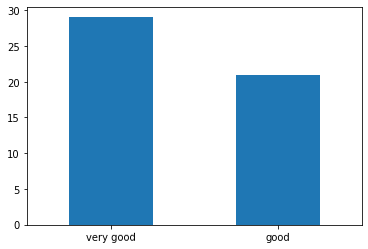

In [7]:
df_rating_class['rating class'].value_counts().plot(kind = 'bar',rot = .3)

In [8]:
# Train data
X = df_rating_class['Cleaned Text']
y_trn = df_rating_class['rating class']

In [9]:
# converting Labels coloumn into numerical form of train data
encoder = LabelEncoder()
y = encoder.fit_transform(y_trn)

In [10]:
encoder.classes_

array(['good', 'very good'], dtype=object)

In [11]:
np.unique(y)

array([0, 1])

In [12]:
encoder.inverse_transform([0, 1])

array(['good', 'very good'], dtype=object)

In [13]:
# train validation split of data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=3,stratify=y)
print('Shape of X_train', X_train.shape, end = ' '), print('Shape of y_train', y_train.shape)
print('Shape of X_valid', X_valid.shape, end = ' '), print('Shape of y_valid', y_valid.shape)
print()

Shape of X_train (45,) Shape of y_train (45,)
Shape of X_valid (5,) Shape of y_valid (5,)



In [36]:
# bag of words representation
tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=100000,use_idf=True,smooth_idf=True)
X_train_bow = tfidf.fit_transform(X_train)  # compressing the data to use less memory
X_train_bow.shape

(45, 100000)

In [37]:
X_valid_bow = tfidf.transform(X_valid)  # compressing the data to use less memory
X_valid_bow.shape

(5, 100000)

### Feature Selection/Importance

In [38]:
transform = tfidf

In [39]:
# convert sparse to dense matrix
X_,y_ = X_train_bow.toarray(),y_train
# print top 10 words/features
top_num = 10

In [40]:
# logistic Regression
model = LogisticRegression()
model.fit(X_,y_) # here I am only taking X_train_bow, y_train. we can also take whole dataset as don't need any accuracy.
# get importance
importance = model.coef_[0]
sorted_index = np.argsort(importance)[::-1] # index of top sorted words
for index in sorted_index[:top_num]:
    print('Feature: %0d, Score: %.7f' % (index,importance[index]))

Feature: 8536, Score: 0.6923795
Feature: 56064, Score: 0.3059591
Feature: 54446, Score: 0.2678354
Feature: 44926, Score: 0.2282055
Feature: 54438, Score: 0.2053562
Feature: 39569, Score: 0.2047111
Feature: 91212, Score: 0.2012579
Feature: 25665, Score: 0.1996615
Feature: 61024, Score: 0.1926020
Feature: 51643, Score: 0.1795680


In [41]:
# Decision Tree
model = DecisionTreeClassifier(random_state=40)
model.fit(X_,y_) # here I am taking whole dataset bec. here I don't need any accuracy. o/w --> X_train_bow, y_train
# get importance
importance = model.feature_importances_
sorted_index = np.argsort(importance)[::-1] # index of top sorted words
# print top 10 words/features
top_num = 10
for index in sorted_index[:top_num]:
    print('Feature: %0d, Score: %.7f' % (index,importance[index]))

Feature: 72776, Score: 0.6688194
Feature: 94205, Score: 0.1681719
Feature: 72909, Score: 0.1630087
Feature: 33334, Score: 0.0000000
Feature: 33326, Score: 0.0000000
Feature: 33327, Score: 0.0000000
Feature: 33328, Score: 0.0000000
Feature: 33329, Score: 0.0000000
Feature: 33330, Score: 0.0000000
Feature: 33331, Score: 0.0000000


In [42]:
# Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_,y_) # here I am only taking X_train_bow, y_train. we can also take whole dataset as don't need any accuracy.
# get importance
importance = model.feature_importances_
sorted_index = np.argsort(importance)[::-1] # index of top sorted words
# print top 10 words/features
top_num = 10
for index in sorted_index[:top_num]:
    print('Feature: %0d, Score: %.7f' % (index,importance[index]))

Feature: 72776, Score: 0.0170185
Feature: 60338, Score: 0.0089879
Feature: 81476, Score: 0.0081079
Feature: 16567, Score: 0.0079654
Feature: 49702, Score: 0.0076672
Feature: 26009, Score: 0.0070330
Feature: 9513, Score: 0.0068364
Feature: 56246, Score: 0.0066882
Feature: 25665, Score: 0.0064470
Feature: 22752, Score: 0.0058286


In [43]:
# anova f-test
fs = SelectKBest(score_func=f_classif, k= 1000) # k is no. of top features;;; select 1000 features then select 10 best
# learn relationship from training data and transform x_train
fs.fit(X_, y_)
# get importance
importance = fs.scores_
sorted_index = np.argsort(importance)[::-1] # index of top sorted words
# print top 10 words/features
top_num = 10
for index in sorted_index[:top_num]:
    print('Feature: %0d, Score: %.7f' % (index,importance[index]))

Feature: 72776, Score: 35.5365500
Feature: 7094, Score: 28.6419986
Feature: 94679, Score: 27.8155862
Feature: 94628, Score: 27.0574509
Feature: 19699, Score: 25.0547345
Feature: 8536, Score: 22.0901378
Feature: 56064, Score: 21.6741952
Feature: 90535, Score: 21.4270530
Feature: 61024, Score: 18.9564821
Feature: 68367, Score: 17.1321873


In [53]:
#  mutual information
fs = SelectKBest(score_func=mutual_info_classif, k= 1000) # k is no. of top features;;; select all features
# learn relationship from training data and transform x_train
fs.fit(X_, y_)
# get importance
importance = fs.scores_
sorted_index = np.argsort(importance)[::-1] # index of top sorted words
# print top 10 words/features
top_num = 10
for index in sorted_index[:top_num]:
    print('Feature: %0d, Score: %.7f' % (index,importance[index]))

Feature: 72776, Score: 0.4034369
Feature: 12346, Score: 0.3904731
Feature: 98116, Score: 0.3771560
Feature: 82483, Score: 0.3598472
Feature: 84612, Score: 0.3581949
Feature: 12368, Score: 0.3557311
Feature: 91443, Score: 0.3532599
Feature: 78283, Score: 0.3393630
Feature: 36015, Score: 0.3391778
Feature: 80560, Score: 0.3375493


Here I am taking Mutual Info as festure selection techinique. So best 10 fetures index are : 72776,36896,23403,94929,63009,49991,42564,46436,913,76416.

In [54]:
best_anova_index = sorted_index[:top_num]
print(f'Top {top_num} words in sorted way are: ')
print()
for i in best_anova_index:
    print(transform.get_feature_names()[i])

Top 10 words in sorted way are: 

really good
call team
work girl
sore
struggle police
camara people
truly inspire performances
seat throughout match
great shame
shows since


### Classification Models

#### NOTE: I change the values of 'fs__k' in clf_parameters according for Tfidf and Word embeddings. Like for word embedding the feature size is 300 so I put the value as 200. But in case of tfidf the feature size is 100000 so change the value accordingly.

In [95]:
def logistic_fs(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    fsl =  SelectKBest(score_func = mutual_info_classif)
    
    print('\n\t ---------- Training Logistic Regression Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    pipeline1 = Pipeline([('fs',fsl),
                          ('clf1', SGDClassifier(n_jobs=-1,loss='log'))])
    clf1_parameters = {
        'fs__k' : [200], # 1000,2000,5000,10000,50000,100000
        'clf1__penalty':['l1', 'l2', 'elasticnet',],
        'clf1__alpha':[0.001,0.01,0.1],
        }
    grid_search1 = GridSearchCV(estimator=pipeline1, param_grid=clf1_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search1.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search1.best_score_}")
    clf1 = grid_search1.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf1) 
    predicted_class_labels1 = clf1.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels1))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf1

In [19]:
clf1_bog = logistic_fs(X_train_bow,X_valid_bow,y_train, y_valid)


	 ---------- Training Logistic Regression Classifier ---------- 

Best score on Training set :  0.8026819846819848


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=50000,
                             score_func=<function mutual_info_classif at 0x00000246CBDCEEE0>)),
                ('clf1', SGDClassifier(alpha=0.1, loss='log', n_jobs=-1))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

Process Completed and time taken is : 131.27 minutes


In [96]:
def KNN_fs(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    fsl =  SelectKBest(score_func = mutual_info_classif)
    print('\n\t ---------- Training KNN Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    pipeline2 = Pipeline([('fs', fsl),
                          ('clf2', KNeighborsClassifier())])
    clf2_parameters = {
        'fs__k' : [200], # 1000,2000,5000,10000,50000,100000
        'clf2__n_neighbors': [1,2,5,10,20,35,],      
        'clf2__weights':['uniform', 'distance',],
        'clf2__p':[1,2,],
        'clf2__metric':['euclidean', 'manhattan',] 
        }
    grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=clf2_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search2.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search2.best_score_}")
    clf2 = grid_search2.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf2) 
    predicted_class_labels2 = clf2.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels2))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf2

In [21]:
clf2_bog = KNN_fs(X_train_bow,X_valid_bow,y_train, y_valid)


	 ---------- Training KNN Classifier ---------- 

Best score on Training set :  0.6321176601176601


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=50000,
                             score_func=<function mutual_info_classif at 0x00000246CBDCEEE0>)),
                ('clf2',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=2, p=1))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

Process Completed and time taken is : 636.47 minutes


In [97]:
def SVM_fs(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    fsl =  SelectKBest(score_func = mutual_info_classif)
    print('\n\t ---------- Training SVM Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    pipeline3 = Pipeline([('fs', fsl),
                          ('clf3', SGDClassifier(n_jobs=-1,early_stopping=True,loss='hinge'))])
    clf3_parameters = {
        'fs__k' : [200], # 1000,2000,5000,10000,50000,100000
        'clf3__penalty':['l1', 'l2', 'elasticnet',],
        'clf3__alpha':[0.001,0.01,0.1,],
        }  
    grid_search3 = GridSearchCV(estimator=pipeline3, param_grid=clf3_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search3.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search3.best_score_}")
    clf3 = grid_search3.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf3) 
    predicted_class_labels3 = clf3.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels3))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf3

In [23]:
clf3_bog = SVM_fs(X_train_bow,X_valid_bow,y_train, y_valid)


	 ---------- Training Linear SVC Classifier ---------- 

Best score on Training set :  0.8011585081585081


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=50000,
                             score_func=<function mutual_info_classif at 0x00000246CBDCEEE0>)),
                ('clf3',
                 SGDClassifier(alpha=0.1, early_stopping=True, n_jobs=-1,
                               penalty='l1'))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

Process Completed and time taken is : 118.06 minutes


In [98]:
def RandomForest_fs(x_t,x_v,y_t, y_v):
    t_start = time.time() # in seconds
    x_train = x_t
    x_valid = x_v
    y_train = y_t
    y_valid = y_v
    
    fsl =  SelectKBest(score_func = mutual_info_classif)
    print('\n\t ---------- Training Random Forest Classifier ---------- \n')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    pipeline4 = Pipeline([('fs', fsl),
                           ('clf4', RandomForestClassifier(class_weight='balanced'))])
    clf4_parameters = {
        'fs__k' : [200], # 1000,2000,5000,10000,50000,100000
        'clf4__criterion':['entropy','gini',],
        'clf4__max_depth':[20,30,50,80,200,],
        'clf4__n_estimators':[30,50,100,],
        'clf4__max_features':['sqrt','log2',None,] 
        } 
    grid_search4 = GridSearchCV(estimator=pipeline4, param_grid=clf4_parameters, n_jobs=-1, cv=cv, scoring='f1_macro')
    grid_search4.fit(x_train,y_train)
    print(f"Best score on Training set :  {grid_search4.best_score_}")
    clf4 = grid_search4.best_estimator_
    print('\n\n The best set of parameters of the pipeline in Training Phase are: ')
    print(clf4) 
    predicted_class_labels4 = clf4.predict(x_valid)  # validation

    print('\n *******  Scores on Validation Data  ******* \n ')
    print(classification_report(y_valid, predicted_class_labels4))
    
    t_ends = time.time() # in seconds
    t_net = (t_ends - t_start)/60    # in minutes
    net_time = round(t_net,2)
    print("====================================================================")
    print(f"Process Completed and time taken is : {net_time} minutes")
    print("====================================================================")
    
    return clf4

In [25]:
clf4_bog = RandomForest_fs(X_train_bow,X_valid_bow,y_train, y_valid)


	 ---------- Training Random Forest Classifier ---------- 

Best score on Training set :  0.6717927627927628


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=100000,
                             score_func=<function mutual_info_classif at 0x00000246CBDCEEE0>)),
                ('clf4',
                 RandomForestClassifier(class_weight='balanced', max_depth=80,
                                        max_features='sqrt',
                                        n_estimators=50))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5

Process Completed and time taken is : 1274.05 minutes


### Word Embedding : Word2Vec

In [82]:
# !python -m spacy download en_core_web_lg

In [86]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [87]:
def word2vec_spacy(X):
    w2v_spacy = []
    for item in X.values: # .values returns dataframe rows as list, eg. 1st sentence as ['he is good']
        doc = nlp(item)
        w2v_spacy.append(doc.vector)
    w2v_spacy = np.array(w2v_spacy)
    return w2v_spacy

In [88]:
# on train data
w2v_spacy_train = word2vec_spacy(X_train)
print(w2v_spacy.shape)

(50, 300)


In [89]:
# on validation data
w2v_spacy_valid = word2vec_spacy(X_valid)
print(w2v_spacy_valid.shape)

(5, 300)


#### Clasifcation on Word embeddings

In [99]:
clf1_we = logistic_fs(w2v_spacy_train,w2v_spacy_valid,y_train, y_valid)


	 ---------- Training Logistic Regression Classifier ---------- 

Best score on Training set :  0.7205773115773115


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=200,
                             score_func=<function mutual_info_classif at 0x000002DAAC088160>)),
                ('clf1',
                 SGDClassifier(alpha=0.01, loss='log', n_jobs=-1,
                               penalty='l1'))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

Process Completed and time taken is : 0.73 minutes


In [100]:
clf2_we = KNN_fs(w2v_spacy_train,w2v_spacy_valid,y_train, y_valid)


	 ---------- Training KNN Classifier ---------- 

Best score on Training set :  0.724143412143412


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=200,
                             score_func=<function mutual_info_classif at 0x000002DAAC088160>)),
                ('clf2',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=20, p=1,
                                      weights='distance'))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

Process Completed and time taken is : 3.78 minutes


In [101]:
clf3_we = SVM_fs(w2v_spacy_train,w2v_spacy_valid,y_train, y_valid)


	 ---------- Training Linear SVC Classifier ---------- 

Best score on Training set :  0.6258258408258408


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=200,
                             score_func=<function mutual_info_classif at 0x000002DAAC088160>)),
                ('clf3',
                 SGDClassifier(alpha=0.01, early_stopping=True, n_jobs=-1,
                               penalty='l1'))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

Process Completed and time taken is : 0.84 minutes


In [102]:
clf4_we = RandomForest_fs(w2v_spacy_train,w2v_spacy_valid,y_train, y_valid)


	 ---------- Training Random Forest Classifier ---------- 

Best score on Training set :  0.753904761904762


 The best set of parameters of the pipeline in Training Phase are: 
Pipeline(steps=[('fs',
                 SelectKBest(k=200,
                             score_func=<function mutual_info_classif at 0x000002DAAC088160>)),
                ('clf4',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        max_features=None, n_estimators=30))])

 *******  Scores on Validation Data  ******* 
 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

Process Completed and time taken is : 9.78 minutes
